In [329]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mbptycho.code.simulation import reloadSimulation
from mbptycho.code.recons.recons import DisplacementFullModelReconstruction
from skimage.feature import register_translation
from skimage.restoration import unwrap_phase
from matplotlib import ticker
from scipy.stats import circmean

import copy
import os
base_path = os.environ['HOME']

cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:

from matplotlib.colors import LogNorm, Normalize, LinearSegmentedColormap
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [4]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

In [5]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005841818181818182)

In [6]:
recons = DisplacementFullModelReconstruction(simulation=sm, shared_magnitudes=True)

Setting background_level to 1e-08...


In [7]:

true_items = {}

if recons._model_type != 'phase':
    #recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items['ux'] = recons._ux_true - recons._ux_true.mean() 

    #recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items['uy'] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':
    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = f"phi{phase_label}"
        
        #rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

In [452]:
xlims = [recons.fwd_model._padx0, recons.fwd_model._padx0 + true_items['ux'].shape[1]]
ylims = [recons.fwd_model._pady0, recons.fwd_model._pady0 + true_items['ux'].shape[0]]

xx = sm.sample.XX_trunc[ylims[0]:ylims[1], xlims[0]:xlims[1], 10]
yy = sm.sample.YY_trunc[ylims[0]:ylims[1], xlims[0]:xlims[1], 10]

ux_plot = sm.sample.Ux_trunc[ylims[0]:ylims[1], xlims[0]:xlims[1], 10][::10,::10]
uy_plot = sm.sample.Uy_trunc[ylims[0]:ylims[1], xlims[0]:xlims[1], 10][::10, ::10]

#mask = np.ones_like(ux_plot).astype('bool')
#mask[5:-5,5:-5] = 0
#ux_plot[mask] = np.nan
#uy_plot[mask] = np.nan

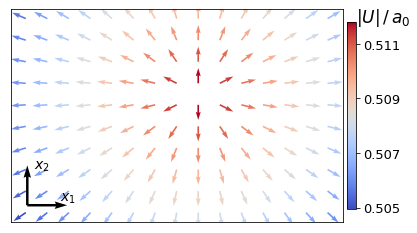

In [483]:
fig, ax = plt.subplots(1,1)
q = plt.quiver(xx[::10,::10], yy[::10,::10], ux_plot, uy_plot,
               (ux_plot**2 + uy_plot**2)**0.5 / sm.sample.params.lattice[0], 
               alpha=1.0, cmap=cmap)
#qk = plt.quiverkey(q, 0.1, 0.1, 2, r'$2 \frac{m}{s}$', labelpos='E', transform=ax.transAxes)
cb = plt.colorbar(shrink=0.7, ticks=[0.505, 0.507, 0.509, 0.511], pad=0.01)
#cb.set_label(label=r'$|U|\,/\,a_0$', size=17, weight='bold',rotation=0, x=10.0,y=1.1)
cb.ax.text(1.0, 1.0,r'$|U|\,/\,a_0$', size=17, weight='bold',rotation=0, transform=cb.ax.transAxes)


cb.ax.tick_params(labelsize=13)
plt.xticks([])
plt.yticks([])
#plt.title('Displacement (true)')
ax.set_aspect('equal')
#plt.xlabel('')

ax.quiver(0.05, 0.08, 0., 0.6, scale=5, color='k', transform=ax.transAxes)
ax.quiver(0.05, 0.08, 0.6, 0, scale=5, color='k', transform=ax.transAxes)

ax.text(0.15, 0.1, r'$x_1$', color='k', fontsize=14, transform=ax.transAxes)
ax.text(0.07, 0.25, r'$x_2$', color='k', fontsize=14, transform=ax.transAxes)
plt.tight_layout()
plt.savefig('displacement_quiver.pdf')
plt.show()

In [454]:
def getNewDisps(m, g=[[1],[0]]):
    g = np.array(g) / sm.sample.params.lattice[0]
    u2 = m.reshape(-1)[:,None] @ g.T / np.linalg.norm(g)**2 
    u2_ux = u2[:,0].reshape(ux_plot.shape)
    u2_uy = u2[:,1].reshape(ux_plot.shape)
    
    ux_new = ux_plot + u2_ux
    uy_new = uy_plot + u2_uy
    
    phases = (ux_new * g[0,0] + uy_new * g[1,0]) * 2 * np.pi
    return g, u2_ux, u2_uy, ux_new, uy_new, phases

In [455]:
def plotStrainComponents(ux, uy):
    
    dux = np.gradient(np.pad(ux, [[2,2], [2,2]]))#, sm.sample.params.sample_pix_size)
    duy = np.gradient(np.pad(uy,[[2,2], [2,2]]))#, sm.sample.params.sample_pix_size)
    du = np.stack([dux, duy], axis=0)
    
    s = np.zeros(du.shape)
    fig, axs = plt.subplots(1,4, figsize=(16,4))
    coord_axes = {0:'y', 1:'x', 2:'z'}
    for i in range(2):
        for j in range(2):
            s[i,j] = 0.5 * (du[j,i] + du[i,j])
            #s[i,j][plots_3d_mask_trunc] = np.nan
            #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
            if i < 2 and j < 2:
                sl = s[i,j, :, :]

            elif i < 2 and j ==2 :
                sl = s[i, j, :,:]
            else:
                sl = s[i, j, :, :]

            im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap)
            axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
            plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
            axs[i * 2 + j].set_xticks([])
            axs[i * 2 + j].set_yticks([])
    plt.suptitle('Strain components', fontsize=17)
    plt.tight_layout()


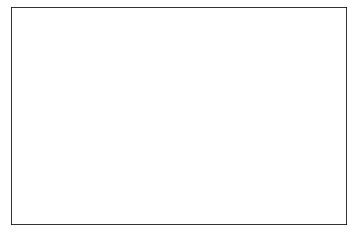

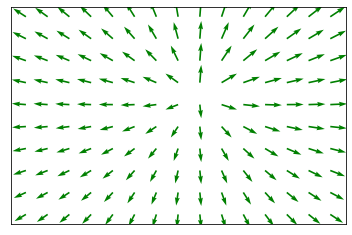

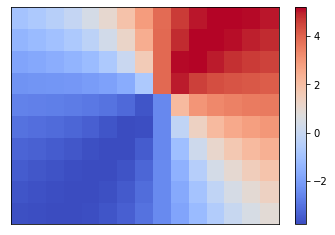

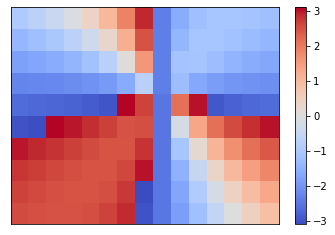

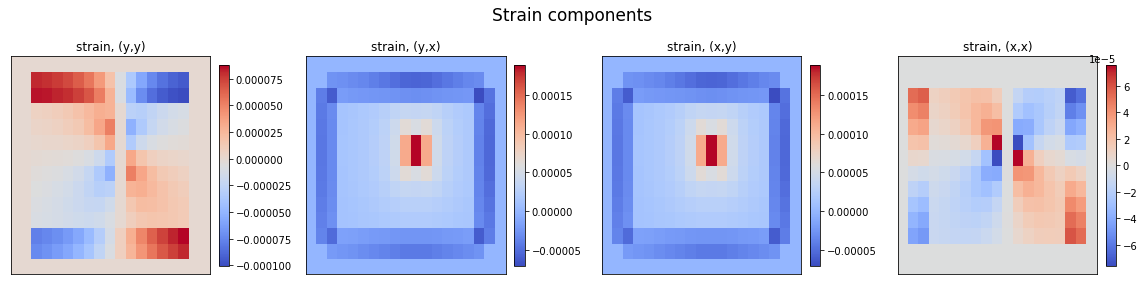

In [325]:
m = np.zeros_like(ux_plot) * 1000
g_this, u2_ux, u2_uy, ux_new, uy_new, phases = getNewDisps(m, [[1], [1]])


plt.quiver(u2_ux, u2_uy, color='red')
plt.xticks([])
plt.yticks([])
plt.show()
plt.quiver(ux_new, uy_new, color='green')
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(phases, cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(np.angle(np.exp(1j * phases)), cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
plotStrainComponents(ux_new, uy_new)

In [326]:
phases_new1 = np.angle(np.exp(1j * phases))

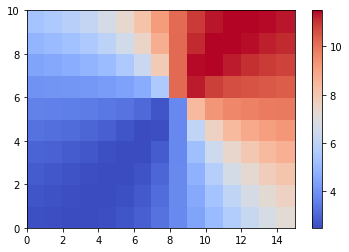

In [328]:
plt.pcolormesh(unwrap_phase(phases_new1), cmap='coolwarm')# * sm.sample.params.lattice[0] / 2 / np.pi)
plt.colorbar()

In [321]:
phases_new2 = np.angle(np.exp(1j * phases))

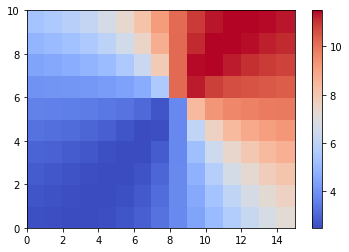

In [324]:
plt.pcolormesh(unwrap_phase(phases_new2), cmap='coolwarm')
plt.colorbar()

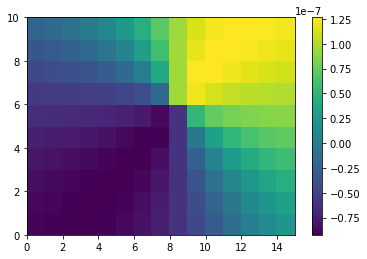

In [302]:
plt.pcolormesh(ux_plot * sm.sample.params.lattice[0] + uy_plot * sm.sample.params.lattice[0])
plt.colorbar()

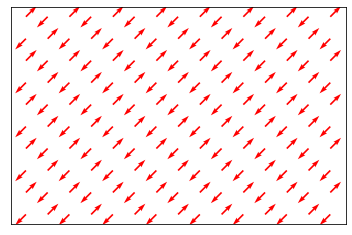

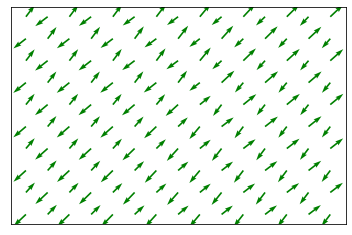

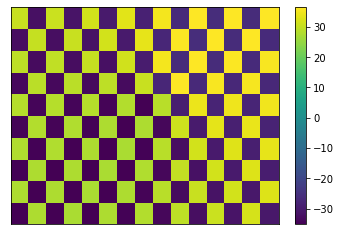

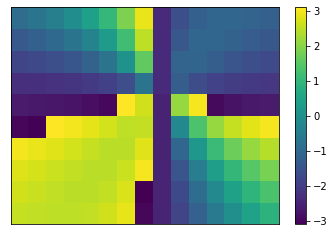

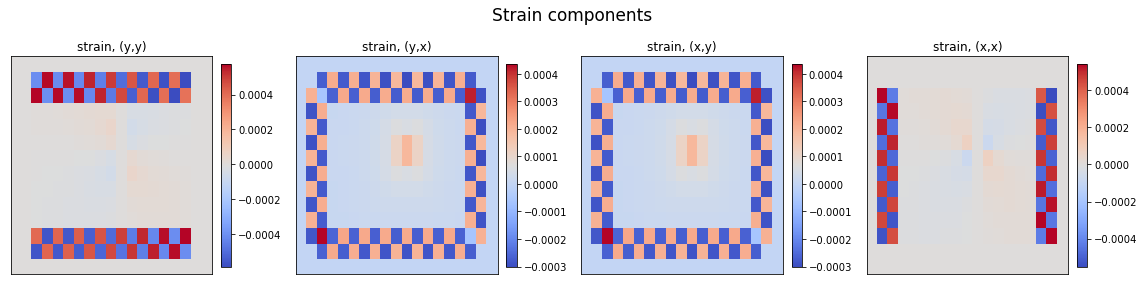

In [330]:
m = np.ones(ux_plot.size) * 5
m[::2] *= -1
g_this, u2_ux, u2_uy, ux_new, uy_new, phases = getNewDisps(m, [[1], [1]])


plt.quiver(u2_ux, u2_uy, color='red')
plt.xticks([])
plt.yticks([])
plt.show()
plt.quiver(ux_new, uy_new, color='green')
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(phases)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(np.angle(np.exp(1j * phases)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
plotStrainComponents(ux_new, uy_new)

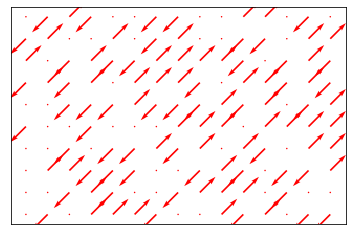

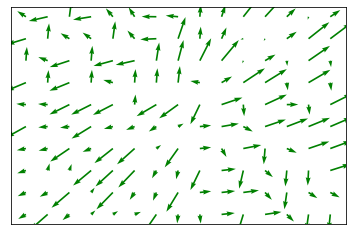

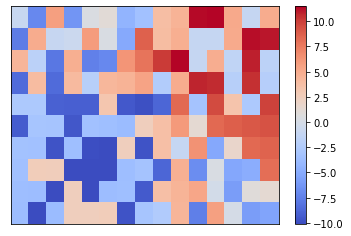

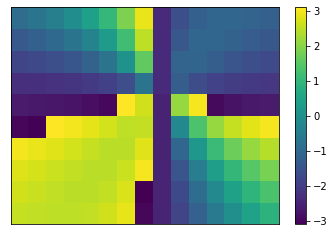

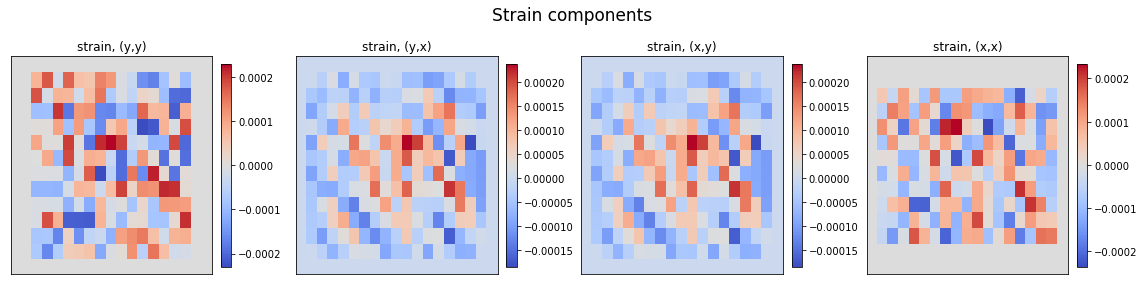

In [320]:
m2 = np.random.randint(-1, 2, size=ux_plot.size).reshape(ux_plot.shape)
#m2[::2] *= -2
#m2[:,::3] *= -1
g_this, u2_ux, u2_uy, ux_new, uy_new, phases = getNewDisps(m2, [[1], [1]])



plt.quiver(u2_ux, u2_uy, color='red')
plt.xticks([])
plt.yticks([])
plt.show()
plt.quiver(ux_new, uy_new, color='green')
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(phases, cmap='coolwarm')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(np.angle(np.exp(1j * phases)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
plotStrainComponents(ux_new, uy_new)

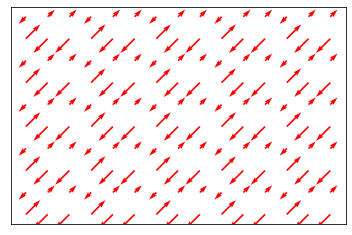

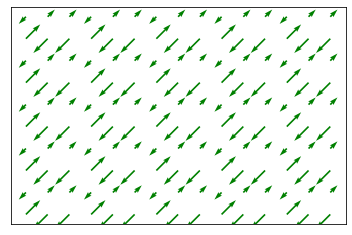

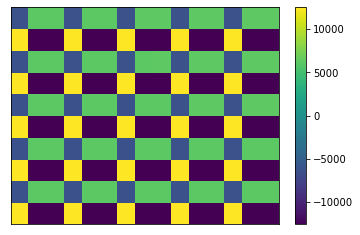

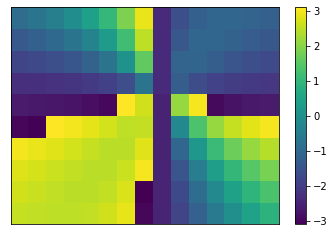

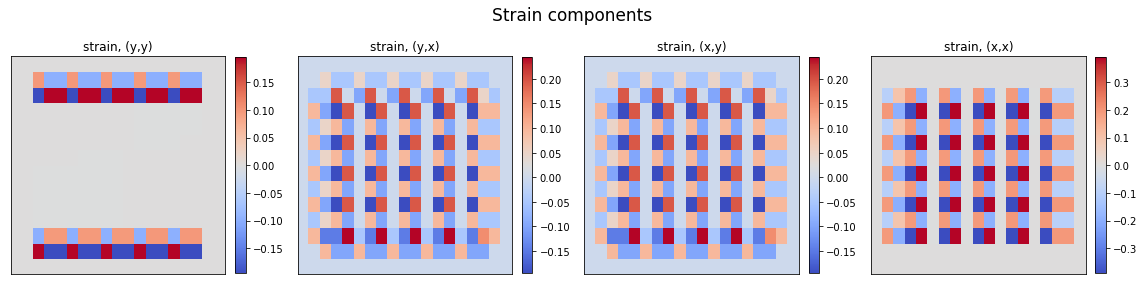

In [305]:
m2 = np.ones_like(ux_plot) * 1000
m2[::2] *= -2
m2[:,::3] *= -1
g_this, u2_ux, u2_uy, ux_new, uy_new, phases = getNewDisps(m2, [[1], [1]])



plt.quiver(u2_ux, u2_uy, color='red')
plt.xticks([])
plt.yticks([])
plt.show()
plt.quiver(ux_new, uy_new, color='green')
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(phases)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

plt.pcolormesh(np.angle(np.exp(1j * phases)))
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()
plotStrainComponents(ux_new, uy_new)

NameError: name 'recons_separate' is not defined

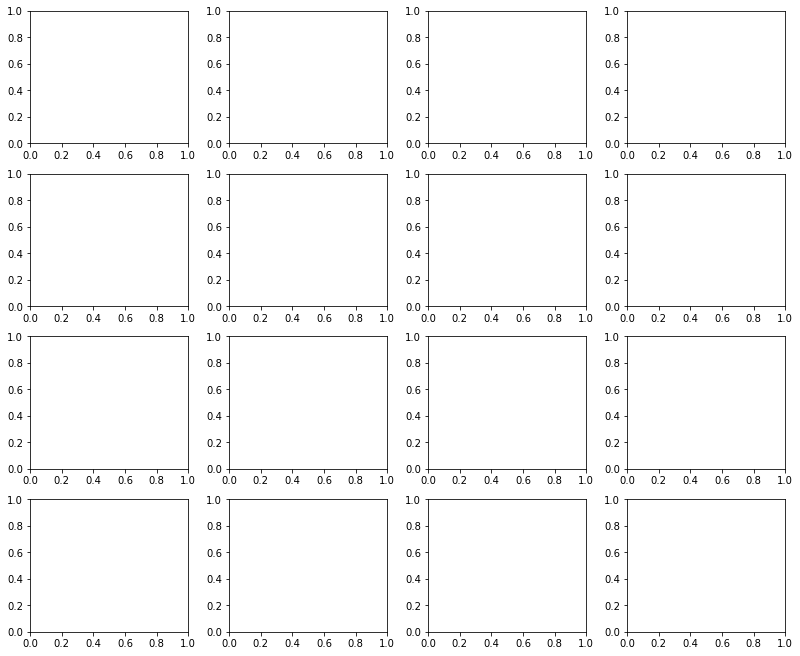

In [286]:
fig, axes = plt.subplots(4, 4, figsize=[11,9], constrained_layout=True)
for i, d in enumerate([true_items, recons_separate, recons_direct, recons_proj]):
    for j in range(4):
        if i == 0:
            rho_true = recons._rho_true[j]
            mag_this = np.abs(rho_true)
        else:
            mag_this = np.abs(d['rho'][j])
        
        mag_this[mag_this < 1e-5] = 1e-5
        #recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        #new_cmap = truncate_colormap(plt.get_cmap('coolwarm'), minval=0.5, maxval=1.0)
        cp = axes[j, i].pcolormesh(mag_this, cmap='jet',
                            norm=LogNorm(vmin=1e-5, vmax=1e-2))
        #cp = axes[j, i].pcolormesh(mag_this, cmap=cmap)#, vmin=-np.pi, vmax=np.pi)
        axes[j, i].set_axis_off()
        axes[j,i].set_aspect('equal')

axes[0, 0].set_title('True', fontsize=14)
axes[0, 1].set_title('TS', fontsize=14)
axes[0, 2].set_title('C-W', fontsize=14)
axes[0, 3].set_title('C-UW', fontsize=14)

axes[0, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{100}|$', fontsize=18, transform=axes[0, 0].transAxes, rotation=90)
axes[1, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{110}|$', fontsize=18, transform=axes[1, 0].transAxes, rotation=90)
axes[2, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{120}|$', fontsize=18, transform=axes[2, 0].transAxes, rotation=90)
axes[3, 0].text(-0.12, 0.5, r'$|\mathcal{O}_{210}|$', fontsize=18, transform=axes[3, 0].transAxes, rotation=90)

axes[3, 0].quiver(0.1, 0.1, 0., 1, scale=5, color='k', transform=axes[3, 0].transAxes)
axes[3, 0].quiver(0.1, 0.1, 1., 0, scale=5, color='k', transform=axes[3, 0].transAxes)

axes[3, 0].text(0.3, 0.1, r'$x_1$', color='k', fontsize=14, transform=axes[3, 0].transAxes)
axes[3, 0].text(0.07, 0.4, r'$x_2$', color='k', fontsize=14, transform=axes[3, 0].transAxes)

axes[0,0].plot(79, 54, "<w")
axes[1,0].plot(79, 54, "<w")
axes[2,0].plot(79, 54, "<w")
axes[3,0].plot(79, 54, "<w")

cb = fig.colorbar(cp, ax=axes[:4, :4], 
                  shrink=0.7, location='bottom', aspect=30, pad=0.005)
#cb.ax.set_xticklabels([r'$-\pi$', r'$-\pi/2$', r'0', r'$\pi/2$', r'$\pi$'])
cb.ax.tick_params(labelsize=13)

plt.savefig('magnitudes.pdf', bbox_inches='tight')